Imports

In [1]:
# standard modules
import copy
import os
import re
import warnings
import time
# 3rd party modules
import yaml
import numpy as np
import pandas as pd
pd.DataFrame.columnstartswith = lambda self, x: [c for c in self.columns if c.startswith(x)]
pd.DataFrame.columnsmatch = lambda self, x: [c for c in self.columns if re.findall(x, c)]


f() Generic use

In [2]:
class structuredData:
    def __init__(self, **kwargs):
        for k, v in kwargs.items(): self.__dict__[k]=v
        pass


def yaml_to_dict(path):
    with open(path, 'r+') as file:
        file = yaml.safe_load(file)
    return file


def list_time_in_period(tmin, tmax, fastfreq, slowfreq, include='both'):
    if include=="left":
        return [(pd.date_range(max(p, pd.to_datetime(tmin)), min(p + pd.Timedelta(slowfreq), pd.to_datetime(tmax)),
          freq=fastfreq)[:-1]) for p in pd.date_range(tmin, tmax, freq=slowfreq).floor(slowfreq)]
    elif include == "right":
        return [(pd.date_range(max(p, pd.to_datetime(tmin)), min(p + pd.Timedelta(slowfreq), pd.to_datetime(tmax)),
          freq=fastfreq)[1:]) for p in pd.date_range(tmin, tmax, freq=slowfreq).floor(slowfreq)]
    elif include == "both":
        return [(pd.date_range(max(p, pd.to_datetime(tmin)), min(p + pd.Timedelta(slowfreq), pd.to_datetime(tmax)),
          freq=fastfreq)) for p in pd.date_range(tmin, tmax, freq=slowfreq).floor(slowfreq)]
    return


def checkifinprogress(path, LIMIT_TIME_OUT=30*60):
    if os.path.exists(path) and (time.time()-os.path.getmtime(path)) < LIMIT_TIME_OUT:
        return 1
    else:
        os.makedirs(os.path.dirname(path), exist_ok=True)
        with open(path, "a+"):
            pass
        return 0


def nanminmax(x):
    return [np.nanmin(x), np.nanmax(x)]


def mkdirs(filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    
def nearest(items, pivot, direction=0):
    if direction == 0:
        nearest = min(items, key=lambda x: abs(x - pivot))
        difference = abs(nearest - pivot)
        
    elif direction == -1:
        nearest = min(items, key=lambda x: abs(x - pivot) if x<pivot else pd.Timedelta(999, "d"))
        difference = (nearest - pivot)
        
    elif direction == 1:
        nearest = min(items, key=lambda x: abs(x - pivot) if x>pivot else pd.Timedelta(999, "d"))
        difference = (nearest - pivot)
    return nearest, difference


def update_nested_dict(d, u):
    for k, v in u.items():
        if isinstance(v, dict):
            d[k] = update_nested_dict(d.get(k, {}), v)
        else:
            d[k] = v
    return d

def update_nested_dicts(*ds, fstr=None):
    r = {}
    for d in ds:
        if isinstance(d, str) and fstr:
            try:
                d = fstr(d)
            except Exception as e:
                continue
        r = update_nested_dict(r, d)
    return r

f() Meteo

In [3]:

def vapour_deficit_pressure(T, RH):
    if np.nanquantile(T, 0.1) < 100 and np.nanquantile(T, 0.9) < 100:
        T = T + 274.15

    # Saturation Vapor Pressure (es)
    #es = 0.6108 * np.exp(17.27 * T / (T + 237.3))
    es = (T **(-8.2)) * (2.7182)**(77.345 + 0.0057*T-7235*(T**(-1)))

    # Actual Vapor Pressure (ea)
    ea = es * RH / 100

    # Vapor Pressure Deficit (Pa)
    return (es - ea)# * 10**(-3)

f() Read data

In [4]:
import datetime
from pandas.api.types import is_numeric_dtype, is_object_dtype
import zipfile
from io import StringIO

DEFAULT_FILE_RAW = {
    'file_pattern': '.*_raw_dataset_([0-9]{12}).csv', 
    'date_format': '%Y%m%d%H%M', 
    'dt': 0.05, 
    'tname': "TIMESTAMP", 
    'id': None,
    'datefomatfrom': '%Y%m%d%H%M%S.%f', 
    'datefomatto': '%Y-%m-%dT%H:%M:%S.%f'
}

DEFAULT_READ_CSV = {
}

DEFAULT_READ_GHG = {
    'skiprows': 7,
    'sep': r"\t"
}

DEFAULT_FMT_DATA = {
}


class structuredDataFrame:
    def __init__(self, data=None, dt=None, **kwargs):
        if data is None:
            loopvar = kwargs.pop('lookup', [])
            loopvar = [l.to_list() if isinstance(l, list)==False else l for l in loopvar]
            for l in loopvar:
                result = universal_reader(lookup=l, **kwargs, verbosity=0)
                self.__dict__.update(result.__dict__)
        
        else:
            assert dt is not None, 'Missing measurement frequency (dt).'
            self.data = data
            self.dt = dt
            self.__dict__.update(**kwargs)
    
    def filter(self, items: dict):
        for k, v in items.items():
            if isinstance(v, tuple):
                self.data = self.data.loc[(self.data[k] > v[0])
                                          & (self.data[k] < v[1])].copy()
            else:
                self.data = self.data[self.data[k].isin(v)].copy()
        return self

    def rename(self, names: dict):
        self.data = self.data.rename(columns=names)
        return self

    def modify(self, items: dict):
        for k, v in items.items():
            self.data[k] = v
        return self

    def format(self, 
               cols={'t':'ts'}, 
               keepcols=['u', 'v', 'w', 'ts', 'co2', 'co2_dry', 'h2o', 'h2o_dry', 'ch4', 'n2o'],
               addkeep=[],
               colsfunc=str.lower, cut=False, **kwargs):
        
        if isinstance(self, pd.DataFrame):
            formated = self
        else:
            fmt_clas = structuredDataFrame(**self.__dict__)
            formated = fmt_clas.data

        if colsfunc is not None:
            formated.columns = map(colsfunc, formated.columns)
        #cols.update(kwargs)
        cols.update({v.lower(): k.lower() for k, v in kwargs.items() if isinstance(v, list)==False})
        cols = {v: k for k, v in {v: k for k, v in cols.items()}.items()}
        cols.update({'timestamp': 'TIMESTAMP'})
        #formated.TIMESTAMP = formated.TIMESTAMP.apply(np.datetime64)
        if cut:
            #formated = formated[[
            #    c for c in formated.columns if c in cols.keys()]]
            formated = formated.loc[:, np.isin(formated.columns, keepcols+addkeep+list(cols.keys()))]
        
        formated = formated.rename(columns=cols)

        if isinstance(self, pd.DataFrame):
            return formated
        else:
            fmt_clas.data = formated
            return fmt_clas
    
    def interpolate(self, cols=["co2", "w"], qcname="qc"):
        interpolated = structuredDataFrame(**self.__dict__)
        interpolated.data[qcname] = 0
        for c_ in list(cols):
            interpolated.data[qcname] = interpolated.data[qcname] + 0 * \
                np.array(interpolated.data[c_])
            interpolated.data.loc[np.isnan(interpolated.data[qcname]), qcname] = 1
            interpolated.data[qcname] = interpolated.data[qcname].astype(int)
            interpolated.data[c_] = interpolated.data[c_].interpolate(method='pad')
            
        return interpolated

'''
Site-specific functions to organise data into a dataframe
Once harmonized it should be ready to be piped through the structuredDataFrame class
Attention, it should include variables such as:
- gas concentration and wind on the right units;
Attention, variables should be continuous (gapfilled if needed);
'''

def universal_reader(path, lookup=[], fill=False, fmt={}, onlynumeric=True, verbosity=1, fkwargs={}, tipfile="readme.txt", **kwargs):
    df_site = pd.DataFrame()
    
    folders = [path + p + '/' for p in os.listdir(path) if os.path.isdir(path + p)]
    folders = folders if folders else [path]
    
    for path_ in folders:
        df_td = pd.DataFrame()

        # read tips file
        kw_ = update_nested_dicts({"FILE_RAW": DEFAULT_FILE_RAW, "READ_CSV": DEFAULT_READ_CSV, "FMT_DATA": DEFAULT_FMT_DATA}, 
                                  os.path.join(path, tipfile), os.path.join(path_, tipfile),
                                  {"FILE_RAW": fkwargs, "READ_CSV": kwargs, "FMT_DATA": fmt},
                                  fstr=lambda d: yaml_to_dict(d))
        
        kw = structuredData(**kw_['FILE_RAW'])
        kw_csv = kw_['READ_CSV']
        
        try:
            if ('header_file' in kw_csv.keys()) and (os.path.exists(kw_csv['header_file'])):
                kw_csv['header_file'] = "[" + open(kw_csv['header_file']).readlines()[0].replace("\n", "") + "]"
        except:
            None
        
        lookup_ = list(set([f.strftime(kw.date_format) for f in lookup]))
        files_list = {}

        for root, directories, files in os.walk(path_):
            for name in files:
                dateparts = re.findall(kw.file_pattern, name, flags=re.IGNORECASE)
                if len(dateparts) == 1:
                    files_list[dateparts[0]] = os.path.join(root, name)
           
        for td in set(lookup_) & files_list.keys() if lookup_ != [] else files_list.keys():
            path_to_tdfile = files_list[td]
            if os.path.exists(path_to_tdfile):
                if path_to_tdfile.endswith('.gz'): kw_csv.update(**{'compression': 'gzip'})
                elif path_to_tdfile.endswith('.csv'): kw_csv.pop('compression', None)
                if path_to_tdfile.endswith('.ghg'):
                    with zipfile.ZipFile(path_to_tdfile, 'r') as zip_ref:
                        datafile = [zip_ref.read(name) for name in zip_ref.namelist() if name.endswith(".data")][0]
                    datafile = str(datafile, 'utf-8')
                    path_to_tdfile = StringIO(datafile)
                    # DEFAULT_READ_GHG
                    kw_csv.update(DEFAULT_READ_GHG)
                try:
                    df_td = pd.read_csv(path_to_tdfile, **kw_csv)
                except Exception as e:
                    # (EOFError, pd.errors.ParserError, pd.errors.EmptyDataError):
                    try:
                        if verbosity>1: warnings.warn(f'{e}, when opening {path_to_tdfile}, using {kw_csv}. Re-trying using python as engine and ignoring bad lines.')
                        df_td = pd.read_csv(path_to_tdfile, on_bad_lines='warn', engine='python', **kw_csv)
                    except Exception as ee:
                        warnings.warn(f'{ee}, when opening {str(path_to_tdfile)}, using {kw_csv}')
                        continue
                
                """
                if kw.tname in df_td.columns:
                    try:
                        df_td.loc[:, kw.tname] = pd.to_datetime(df_td.loc[:, kw.tname].astype(str))
                        print(max(df_td[kw.tname].dt.year), max(df_td[kw.tname]), min(df_td[kw.tname].dt.year))
                        assert max(df_td[kw.tname].dt.year) > 1990 and min(df_td[kw.tname].dt.year) > 1990
                    except:
                        df_td.rename({kw.tname+'_orig': kw.tname})
                """
                if kw.datefomatfrom == 'drop':
                    df_td = df_td.rename({kw.tname: kw.tname+'_orig'})
                
                if kw.tname not in df_td.columns or kw.datefomatfrom == 'drop':
                    if "date" in df_td.columns and "time" in df_td.columns:
                        df_td[kw.tname] = pd.to_datetime(
                            df_td.date + " " + df_td.time, format='%Y-%m-%d %H:%M')
                    else:
                        df_td[kw.tname] = pd.to_datetime(
                            td, format=kw.date_format) - datetime.timedelta(seconds=kw.dt) * (len(df_td)-1 + -1*df_td.index)
                            #td, format=kw.date_format) + datetime.timedelta(seconds=kw.dt) * (df_td.index)
                        df_td[kw.tname] = df_td[kw.tname].dt.strftime(
                            kw.datefomatto)
                else:
                    try:
                        if is_numeric_dtype(df_td[kw.tname]):
                            df_td.loc[:, kw.tname] = df_td.loc[:, kw.tname].apply(lambda e: pd.to_datetime('%.2f' % e, format=kw.datefomatfrom).strftime(kw.datefomatto))
                        elif is_object_dtype(df_td[kw.tname]):
                            df_td.loc[:, kw.tname] = df_td.loc[:, kw.tname].apply(lambda e: pd.to_datetime(e).strftime(kw.datefomatto))
                        else:
                            df_td.loc[:, kw.tname] = pd.to_datetime(df_td[kw.tname], format=kw.datefomatfrom).strftime(kw.datefomatto)
                    except:
                        warnings.warn(f'error when converting {kw.tname} from {kw.datefomatfrom} to {kw.datefomatto}.')
                        continue
                
                df_td['file'] = td
                #df_site = df_site.append(df_td)
                df_site = pd.concat([df_site, df_td], ignore_index=True).reset_index(drop=True)
        
        if df_td.empty == False:
            break
        
    #print('df_td.empty ', df_td.empty)
    if onlynumeric:
        valcols = [i for i in df_site.columns if i.lower() not in [kw.tname.lower(), 'file']]
        _bf = df_site.dtypes
        #df_site.loc[:, valcols] = df_site.loc[:, valcols].apply(pd.to_numeric, errors='coerce')
        df_site[valcols] = df_site[valcols].apply(pd.to_numeric, errors='coerce')
        _af = df_site.dtypes
        if verbosity>1:
            _bfaf = []
            for (k, b) in _bf.items():
                if b!=_af[k]:
                    _nonnum = [s for s in np.unique(df_site[k].apply(lambda s: str(s) if re.findall('[A-z/]+', str(s)) else '')) if s]
                    _bfaf += ['{}, changed from {} to {}. ({})'.format(k, b, _af[k], ', '.join(_nonnum) if _nonnum else 'All numeric')]
            if _bfaf:
                warnings.warn(', '.join(_bfaf))
    
    #if kw_fmt:
    df_site = structuredDataFrame.format(df_site, **kw_['FMT_DATA'])

    if fill:
        if lookup:
            minmax = [min(lookup), max(lookup)]
        else:
            minmax = [np.nanmin(df_site[kw.tname]),
                      np.nanmax(df_site[kw.tname])]
        df_site = df_site.set_index(kw.tname).join(pd.DataFrame({kw.tname: pd.date_range(*minmax, freq=str(kw.dt) + ' S')}).set_index(kw.tname),
                how='outer').ffill().reset_index()
        #if 'co2' in df_site.columns and (abs(np.max(df_site.co2)) < 1000) and (abs(np.min(df_site.co2)) < 1000):
        #    df_site.loc[:, "co2"] = df_site.loc[:, "co2"] * 1000  # mmol/m3 -> μmol/m3
    
    if kw.id is not None:
        return {kw.id: structuredDataFrame(df_site, dt=kw.dt)}
    else:
        return structuredDataFrame(df_site, dt=kw.dt)


Backing off send_request(...) for 0.6s (requests.exceptions.ConnectionError: HTTPSConnectionPool(host='api.segment.io', port=443): Max retries exceeded with url: /v1/batch (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002CD24B81CD0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')))


f() Despiking

In [ ]:
def use_despike(self, cols=['u', 'v', 'w', 'co2', 'h2o'], script='Py', fup2=.1, output_index=None, **kwargs):
    
    plausibility_range = {'u': 3.5, 'v': 3.5, 'w': 5, 'co2': 3.5, 'h2o': 3.5}

    if not callable(script):
        if script=='RFlux':
            # not included
            script = tcom.LazyCallable(os.path.join(
                cfp.parent, "RFlux-scripts/despiking.R"), "despiking").__get__().fc
            output_index = 0
            kwargs_ = {'mfreq': 20, 'variant': "v3", 'wsignal': 7, 'wscale': 20*60*30/6, 'zth': plausibility_range.get(c, 5)}
            kwargs_.update(kwargs)
        
        elif script == 'OCE':
            # not included
            script = tcom.LazyCallable(os.path.join(
                cfp.parent, "corrections/oce_despike.R"), "despike").__get__().fc
            kwargs_ = {'n': plausibility_range.get(c, 5)}
            kwargs_.update(kwargs)
        
        else:
            script = mauder2013
            kwargs.pop("fill", None)

    for c in cols:
        ogap = np.isnan(self[c])

        '''
        # take off absurdity numbers
        p1 = np.nanquantile(self[c], 0.01)
        p99 = np.nanquantile(self[c], 0.99)
        absurdity_bounds_min = 10**(-3 if p1 > 0 else 3) * p1
        absurdity_bounds_max = 10**(3 if p99 > 0 else -3) * p99
        print(p1, p99)
        print("np.nanmedian(x)", np.nanmedian(self[c]), np.median(self[c]))
        self[c].mask(self[c] < absurdity_bounds_min, np.nan, inplace=True)
        self[c].mask(self[c] > absurdity_bounds_max, np.nan, inplace=True)
        print("np.nanmedian(x)", np.nanmedian(self[c]), np.median(self[c]))
        '''
        
        if output_index:
            self.loc[:, c] = script(self[c], **kwargs)[output_index]
        else:
            self.loc[:, c] = script(self[c], **kwargs)
        
        ngap = np.isnan(self[c])
        N = len(self)
        
        # fill all nans
        self.loc[:, c] = np.interp(np.linspace(0, 1, N),
                            np.linspace(0, 1, N)[ngap == False],
                            self[c][ngap == False])
        # put back the original nans
        self[c].mask(ogap, np.nan, inplace=True)

    return self


def mauder2013(x, q=7):
    x = np.array(x)
    x_med = np.nanmedian(x)
    mad = np.nanmedian(np.abs(x - x_med))
    bounds = (x_med - (q * mad) / 0.6745, x_med + (q * mad) / 0.6745)
    #print("median", x_med, "mad", mad, "bounds", bounds)
    x[x < min(bounds)] = np.nan
    x[x > max(bounds)] = np.nan

    #if fill is not None:
    #    x = fill(pd.Series(x) if fill in (pd.Series.ffill, pd.Series.interpolate) else x)
    return x


f() Wavelet-related

In [5]:
# standard modules

# 3rd party modules
import pywt
import pycwt
import itertools
import warnings
import pycwt as wavelet
#from Lib.OpenFlux.scripts import get_rawdata, common as tt
from functools import reduce
import fcwt


def calculate_coi(N, dt=0.05, param=6, mother="MORLET"):
    # from Torrence and Compo

    # fourier factor (c)
    # _, _, c, _ = wv_tc.wave_bases(
    #    mother=mother, k=np.array([-1, -1]), scale=-1, param=param)
    # coi = c * dt * np.concatenate((
    #        np.insert(np.arange(int((N + 1) / 2) - 1), [0], [1E-5]),
    #        np.insert(np.flipud(np.arange(0, int(N / 2) - 1)), [-1], [1E-5])))

    # from pycwt
    # fourier factor (c)
    c = wavelet.flambda() * wavelet.coi()
    coi = (N / 2 - np.abs(np.arange(0, N) - (N - 1) / 2))
    coi = c * dt * coi
    return coi

def coitomask(coi, shape, scales, false=False):
    #  freq |_____ 
    #         time
    coi_mask = np.ones(shape, dtype = bool)
    tx = shape[0] if shape[0] == len(coi) else shape[1]
    fx = shape[1] if shape[0] == len(coi) else shape[0]
    
    for i in range(tx):
        print("i", i, tx)
        coi_period_threshold = list(scales).index(
            nearest(scales, coi[i])[0])

        for j in range(coi_period_threshold, fx):
            print("i", i, "j", j, fx, "coi_period_threshold", coi_period_threshold)
            coi_mask[i][j] = false
    return coi_mask


def bufferforfrequency_dwt(N=0, n_=30*60*20, fs=20, level=None, f0=None, max_iteration=10**4, wave='db6', **kw):
    if level is None and f0 is None: level = 18
    lvl = level if level is not None else int(np.ceil(np.log2(fs/f0)))
    n0 = N
    cur_iteration = 0
    while True:
        n0 += pd.to_timedelta(n_)/pd.to_timedelta("1S") * fs if isinstance(n_, str) else n_
        if lvl <= pywt.dwt_max_level(n0, wave):
            break
        cur_iteration += 1
        if cur_iteration > max_iteration:
            warnings.warn('Limit of iterations attained before buffer found. Current buffer allows up to {} levels.'.format(
                pywt.dwt_max_level(n0, wave)))
            break
    return (n0-N) * fs**-1


def bufferforfrequency(f0, dt=0.05, param=6, mother="MORLET", wavelet=pycwt.Morlet(6)):
    #check if f0 in right units
    # f0 ↴
    #    /\
    #   /  \
    #  /____\
    # 2 x buffer
    
    # _, _, c, _ = wv_tc.wave_bases(mother=mother, k=np.array([-1, -1]), scale=-1, param=param)
    c = wavelet.flambda() * wavelet.coi()
    n0 = 1 + (2 * (1/f0) * (c * dt)**-1)
    N = int(np.ceil(n0 * dt))

    # xmax = f0 / (c * dt)
    # N = ((xmax + 2) * 2) - 1
    # N int(np.ceil(N * dt)) #(1 / (λ * c)) * f0
    return N


def cwt(input, fs, f0, f1, fn, nthreads=1, scaling="log", fast=False, norm=True, Morlet=6.0):

    #check if input is array and not matrix
    if input.ndim > 1:
        raise ValueError("Input must be a vector")

    #check if input is single precision and change to single precision if not
    if input.dtype != 'single':
        input = input.astype('single')

    morl = fcwt.Morlet(Morlet) #use Morlet wavelet with a wavelet-parameter

    #Generate scales

    if scaling == "lin":
        scales = fcwt.Scales(morl,fcwt.FCWT_LINFREQS,fs,f0,f1,fn)
    elif scaling == "log":
        scales = fcwt.Scales(morl,fcwt.FCWT_LOGSCALES,fs,f0,f1,fn)
    else:
        scales = fcwt.Scales(morl,fcwt.FCWT_LOGSCALES,fs,f0,f1,fn)

    _fcwt = fcwt.FCWT(morl, int(nthreads), fast, norm)

    output = np.zeros((fn,input.size), dtype='csingle')
    freqs = np.zeros((fn), dtype='single')
    
    _fcwt.cwt(input,scales,output)
    scales.getFrequencies(freqs)

    return freqs, output


def icwt(W, sj, dt, dj, Cd=None, psi=None, wavelet=pycwt.wavelet.Morlet(6)):
    if Cd is None: Cd = wavelet.cdelta
    if psi is None: psi = wavelet.psi(0)
        
    a, b = W.shape
    c = sj.size
    if a == c:
        sj_ = (np.ones([b, 1]) * sj).transpose()
    elif b == c:
        sj_ = np.ones([a, 1]) * sj
    
    x = (W.real / (sj_ ** .5)) * ((dj * dt ** .5) / (Cd * psi))
    return x

   
def dwt(signal, level=None, wave="db6"):
    Ws = []
    if np.array(signal).ndim == 1:
        signal = [signal]
    for X in signal:
        Ws += [pywt.wavedec(X, wave, level=level)]
    level = len(Ws[-1])-1
    return Ws


def idwt(coefs, N, level=None, wave="db6"):
    #assert sum([s==level for s in W.shape]), "Coefficients don't have the same size as level."
    def wrcoef(N, coef_type, coeffs, wavename, level):
        a, ds = coeffs[0], list(reversed(coeffs[1:]))

        if coef_type == 'a':
            return pywt.upcoef('a', a, wavename, level=level, take=N)  # [:N]
        elif coef_type == 'd':
            return pywt.upcoef('d', ds[level-1], wavename, level=level, take=N)  # [:N]
        else:
            raise ValueError("Invalid coefficient type: {}".format(coef_type))
    
    Ys = []
    for W in coefs:
        A1 = wrcoef(N, 'a', W, wave, level)
        D1 = [wrcoef(N, 'd', W, wave, i) for i in range(1, level+1)]
        Ys += [np.array(D1 + [A1])]
    return Ys, level

def loaddatawithbuffer(d0, d1=None, freq=None, buffer=None, 
                       tname="TIMESTAMP", **kwargs):
    if isinstance(d0, (pd.DatetimeIndex)):
        d0, d1 = [np.nanmin(d0), np.nanmax(d0)]
    
    if buffer == None:
        datarange = [pd.date_range(start=d0, end=d1, freq=freq)[:-1] + pd.Timedelta(freq)]
    else:
        freqno = int(re.match("\d*", "30min")[0])
        
        bufi = np.ceil(buffer / (freqno*60)) * freqno
        datarange = [
            pd.date_range(
                start=pd.to_datetime(d0) - pd.Timedelta(bufi, unit='min'),
                end=pd.to_datetime(d1) + pd.Timedelta(bufi, unit='min'),
                freq=freq)[:-1] + pd.Timedelta(freq)]
                
    if not datarange:
        return pd.DataFrame()
    
    data = structuredDataFrame(lookup=datarange, **kwargs)
    if data == None or data.data.empty:
        return data.data
    data.data[tname] = pd.to_datetime(data.data[tname])
    
    if buffer:
        d0 = pd.to_datetime(d0) - pd.Timedelta(buffer*1.1, unit='s')
        d1 = pd.to_datetime(d1) + pd.Timedelta(buffer*1.1, unit='s')
        data.filter({tname: (d0, d1)})

    # garantee all data points, if any valid time, else empty dataframe
    if np.sum(np.isnat(data.data.TIMESTAMP)==False):
        data.data = pd.merge(pd.DataFrame({tname: pd.date_range(*nanminmax(data.data.TIMESTAMP), freq="0.05S")}),
                            data.data,
                            on=tname, how='outer').reset_index(drop=True)
        return data.data
    else:
        pd.DataFrame()


def matrixtotimetable(time, mat, c0name="TIMESTAMP", **kwargs):
    assert len(time) in mat.shape, f"Time ({time.shape}) and matrix ({mat.shape}) do not match."
    mat = np.array(mat)

    if len(time) != mat.shape[0] and len(time) == mat.shape[1]:
        mat = mat.T

    __temp__ = pd.DataFrame(mat, **kwargs)
    __temp__.insert(0, c0name, time)

    return __temp__


def conditional_sampling(Y12, *args, level=None, wave="db6", false=0):
    nargs = len(args) + 1
    YS = [Y12] + list(args)
    #YS, _ = decompose(*args, level=level, wave=wave)
    #Yi = {}
    Ys = {}
    label = {1: "+", -1: "-"}

    for co in set(itertools.combinations([1, -1]*nargs, nargs)):
        name = 'xy{}a'.format(''.join([label[c] for c in co]))
        Ys[name] = Y12
        for i, c in enumerate(co):
            xy = 1 * (c*YS[i] >= 0)
            #xy[xy==0] = false
            xy = np.where(xy == 0, false, xy)
            Ys[name] = Ys[name] * xy
    return Ys


def universal_wt(signal, method, fs=20, f0=1/(3*60*60), f1=10, fn=100, 
                 dj=1/12, inv=True, **kwargs):
    assert method in [
        'dwt', 'cwt', 'fcwt'], "Method not found. Available methods are: dwt, cwt, fcwt"
    if method== "dwt":
        lvl = kwargs.pop('level', int(np.ceil(np.log2(fs/f0))))
        # _l if s0*2^j; fs*2**(-_l) if Hz; (1/fs)*2**_l if sec.
        sj = [_l for _l in np.arange(1, lvl+2, 1)]
        waves = dwt(signal, level=lvl, **kwargs)
        if inv:
            N = np.array(signal).shape[-1]
            waves = idwt(waves, N=N, level=lvl, **kwargs)
        wave = waves[0][0]
    elif method == 'fcwt':
        _l, wave = cwt(signal, fs, f0, f1, fn, **kwargs)
        sj = np.log2(fs/_l)
        if inv:
            wave = icwt(wave, sj=sj, dt=fs, dj=dj, **kwargs, 
                        mother=pycwt.wavelet.Morlet(6))
    elif method == 'cwt':
        wave, sj, _, _, _, _ = pycwt.cwt(
            signal, dt=1/fs, s0=2/fs, dj=dj, J=fn-1)
        sj = np.log2(sj*fs)
        if inv:
            wave = icwt(wave, sj=sj, dt=fs**-1, dj=dj, **kwargs)
    return wave, sj


def wavelet_nearest_freq(wvlst, obs, period):
    wvlst_cs = np.array([np.cumsum(f) for f in wvlst])
    _freqs = [np.where(wvlst_cs[f] == nearest(wvlst_cs[f], obs[f])[0])[
        0][0] for f in range(len(wvlst))]
    _periods = [period[f] for f in _freqs]
    return _freqs, _periods


def run_dwt(ymd, varstorun, raw_kwargs, output_path, dwv_kwargs={'method': 'dwt'}, averaging=[30], condsamp=[],
                                integrating=15, overwrite=False, despike=True, file_duration="1D", verbosity=1):
    if verbosity: print('\nRUNNING MULTILEVEL DECOMPOSITION\n')
    lvl = dwv_kwargs.get("level", integrating+3)
    dwv_kwargs.update({"level": lvl})
    
    suffix = raw_kwargs['suffix'] if 'suffix' in raw_kwargs.keys() else ''
    
    # from START, END, FREQ to list of dates
    # ymd = np.unique(['{}{}{}'.format(d.year, str(d.month).zfill(2), str(d.day).zfill(2)) for d in list_of_dates(*ymd)])
    
    d0, d1, _f = ymd
    ymd = list_time_in_period(*ymd, file_duration)
    buffer = bufferforfrequency(20/(2**dwv_kwargs['level'])) / 2

    for i, yl in enumerate(ymd):
        y = re.sub('[-: ]', '', yl.strftime('%')[0])
        if file_duration.endswith("D"): y = y[:8]
        if file_duration.endswith("H") or file_duration.endswith("Min"): y = y[:12]
        #y = '{}{}{}'.format(yl[0].year, str(yl[0].month).zfill(2), str(yl[0].day).zfill(2))

        # check if files exist and overwrite option
        if not overwrite:
            avg_ = []
            for a in averaging:
                if not overwrite and os.path.exists(output_path.format(suffix, y, str(a).zfill(2))):
                    avg_ += [a]
            avg_ = list(set(averaging)-set(avg_))
            if not avg_:
                if verbosity > 1: warnings.warn("exists: File already exists ({}).".format(y))
                continue
        else:
            avg_ = [a for a in averaging]
        
        curoutpath_inprog = output_path.format(suffix, str(y), "").rsplit(".", 1)[0] + ".inprogress"
        if checkifinprogress(curoutpath_inprog): continue
        
        # load files
        df = loaddatawithbuffer(
            yl, d1=None, freq=_f, buffer=buffer, **raw_kwargs)
        
        if df.empty:
            if verbosity>1: warnings.warn("exit1: No file was found ({}).".format(y))
            if os.path.exists(curoutpath_inprog): os.remove(curoutpath_inprog)
            continue

        df.TIMESTAMP = pd.to_datetime(df.TIMESTAMP)
        
        df = pd.merge(pd.DataFrame({"TIMESTAMP": pd.date_range(*nanminmax(df.TIMESTAMP), freq="0.05S")}),
                            df,
                            on="TIMESTAMP", how='outer').reset_index(drop=True)
        
        dat_fullspectra = {a: [] for a in avg_}
        dat_fluxresult = {a: [] for a in avg_}

        # run by couple of variables (e.g.: co2*w -> mean(co2'w'))
        for xy, condsamp in [(v.split('*')[:2], v.split('*')[2:3]) for v in varstorun]:
            Xs = []
            Xnas = []
            for xy_ in xy:
                X = df[xy_]  # .interpolate(limit_direction="both")
                Xna = np.isnan(X)
                X = np.interp(np.linspace(0, 1, len(X)),
                                np.linspace(0, 1, len(X))[Xna == False],
                                X[Xna == False])
                Xnas += [np.isnan(X)]
                Xs += [X - np.mean(X)]

            # run multilevel decomposition
            #Y12, level = mld.multilevelflux.get_flux(*Xs, **dwv_kwargs)
            #Y12[:, (X1na | X2na)] = np.nan
            Y1, sj = universal_wt(Xs[0], **dwv_kwargs)
            Y2,  _ = universal_wt(Xs[1], **dwv_kwargs)
            level = max(sj)
            Y12 = Y1 * Y2.conjugate()
            Ys = {''.join(xy): Y12}

            Xcs = []
            for cs_ in condsamp:
                X = df[cs_]  # .interpolate(limit_direction="both")
                Xna = np.isnan(X)
                X = np.interp(np.linspace(0, 1, len(X)),
                              np.linspace(0, 1, len(X))[Xna == False],
                              X[Xna == False])
                Xcs += [X - np.mean(X)]
            if len(Xcs)==2:
                Xc1, _ = universal_wt(Xcs[0], **dwv_kwargs)
                Xc2, _ = universal_wt(Xcs[1], **dwv_kwargs)
            elif len(Xcs) == 1:
                condsamp = [xy[0]] + condsamp
                Xc2, _ = universal_wt(Xcs[0], **dwv_kwargs)
                Xc1 = Y1
            if Xcs:
                Xc12 = Xc1 * Xc2.conjugate()
            
            Ycs = conditional_sampling(Y12, Xc12) if Xcs else {}
            nnames = {}
            for k in Ycs.keys():
                nname = str(k)
                for i, cs_ in enumerate(condsamp):
                    nname = nname.replace(f"x{i}", cs_)
                nnames[k] = nname
            for old, new in nnames.items():
                Ycs[new] = Ycs.pop(old)
            Ys.update({k.replace("xy", ''.join(xy)).replace('a', ''.join(condsamp)): v for k, v in Ycs.items()})

            # ARRAY TO DATAFRAME THEN AVG
            def __arr2dataframe__(Y, prefix=''.join(xy), id=np.array(df.TIMESTAMP)):
                __temp__ = matrixtotimetable(id, Y, columns=[
                        "{}_{}".format(prefix, l) for l in range(level)]) #+ ["{}_r".format(prefix)]
                __temp__["qc_{}".format(prefix)] = (Xnas[0] | Xnas[1]) * 1
                __temp__ = __temp__[__temp__.TIMESTAMP > min(yl)]
                __temp__ = __temp__[__temp__.TIMESTAMP <= max(yl)]
                return __temp__
            
            __temp__ = reduce(lambda left, right: pd.merge(left, right[['TIMESTAMP'] + list(right.columns.difference(left.columns))], on="TIMESTAMP", how="outer"),
                              [__arr2dataframe__(Y, n) for n, Y in Ys.items()])
            
            for a in avg_:
                __tempa__ = copy.deepcopy(__temp__)
                __tempa__["TIMESTAMP"] = pd.to_datetime(np.array(__tempa__.TIMESTAMP)).ceil(
                    str(a)+'Min')
                __tempa__ = __tempa__.groupby("TIMESTAMP").agg(np.nanmean).reset_index()
                #__tempcond = (nan_tolerance < 1 and np.array(__tempa__["qc"]) > nan_tolerance) + (np.array(__tempa__["qc"]) > (nan_tolerance * len(__tempa__) / len(__temp__)))
                #__tempa__.loc[__tempcond>0, [c for c in __tempa__.columns if c != "TIMESTAMP"]] = np.nan

                if Xcs:
                    for c in ['++', '+-', '--', '-+']:
                        __tempa__.insert(1, ''.join(xy) + c + ''.join(condsamp), np.sum(__tempa__[[
                            "{}_{}".format(''.join(xy) + c + ''.join(condsamp), l) for l in range(level) if l < integrating]], axis=1))
                __tempa__.insert(1, ''.join(xy), np.sum(__tempa__[[
                    "{}_{}".format(''.join(xy), l) for l in range(level) if l < integrating]], axis=1))

                dat_fullspectra[a] += [__tempa__]
                cs_ = [''.join(xy) + c + ''.join(condsamp) for c in ['++','+-', '--','-+']] if Xcs else []
                dat_fluxresult[a] += [__tempa__[["TIMESTAMP", ''.join(xy)] + cs_]]
                del __tempa__  # , __tempcond
        
        for a in avg_:
            dat_fullspectra[a] = reduce(lambda left, right: pd.merge(left, right, on="TIMESTAMP", how="outer"),
                                 dat_fullspectra[a])
            dat_fluxresult[a] = reduce(lambda left, right: pd.merge(left, right, on="TIMESTAMP", how="outer"),
                                 dat_fluxresult[a])
            
            if despike:
                # despike
                dat_fullspectra[a] = use_despike(dat_fullspectra[a], cols=[c for c in dat_fullspectra[a].columns if not c == 'TIMESTAMP'])
                dat_fluxresult[a] = use_despike(dat_fluxresult[a], cols=[c for c in dat_fullspectra[a].columns if not c == 'TIMESTAMP'])
            
            mkdirs(output_path.format(suffix, str(y), str(a).zfill(2)))
            dat_fullspectra[a].to_csv(output_path.format(suffix + "_full_cospectra", str(y), str(a).zfill(2)), index=False)
            dat_fluxresult[a].to_csv(output_path.format(suffix, str(y), str(a).zfill(2)), index=False)
                
        if os.path.exists(curoutpath_inprog): os.remove(curoutpath_inprog)
        if verbosity: print(y, len(yl), f'{int(100*i/len(ymd))} %', end='\n')


Backing off send_request(...) for 5.7s (requests.exceptions.ConnectionError: HTTPSConnectionPool(host='api.segment.io', port=443): Max retries exceeded with url: /v1/batch (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002CD2576ACD0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')))


Calculate flux

In [6]:
configure = structuredData()

# Select averaging period
configure.averaging = [30, 5]

# Select output file path
configure.output_path = os.path.join(os.getcwd(), 'data/FR-Fon_DWT{}_{}.{}mn.csv')

# Select input file path
configure.raw_kwargs = {'path': os.path.join(os.getcwd(), 'data/FR-Fon/eddypro_raw_datasets/')}

# Select covariances
# x*y → Cov(x, y)
# x*y*z*... → Cov(x, y)|Cov(x, z)|Cov(x, ...) (not yet implemented)
configure.varstorun = ['w*co2*h2o*ts', 'w*h2o*co2', 'w*ts*co2']

# Select period of interest
# [START_DATE, END_DATE, FILE_FREQUENCY]
configure.ymd = ['202112310030', '202201020000', '30min']

rdw = run_dwt(**vars(configure), verbosity=5)



RUNNING MULTILEVEL DECOMPOSITION



c:\Users\phherigcoimb\Anaconda3\envs\talltower\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 18 is too high: all coefficients will experience boundary effects.
  warnings.warn(
c:\Users\phherigcoimb\Anaconda3\envs\talltower\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 18 is too high: all coefficients will experience boundary effects.
  warnings.warn(
c:\Users\phherigcoimb\Anaconda3\envs\talltower\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 18 is too high: all coefficients will experience boundary effects.
  warnings.warn(


20211231 48 0 %


c:\Users\phherigcoimb\Anaconda3\envs\talltower\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 18 is too high: all coefficients will experience boundary effects.
  warnings.warn(
c:\Users\phherigcoimb\Anaconda3\envs\talltower\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 18 is too high: all coefficients will experience boundary effects.
  warnings.warn(
c:\Users\phherigcoimb\Anaconda3\envs\talltower\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 18 is too high: all coefficients will experience boundary effects.
  warnings.warn(


20220101 49 0 %


f() Gapfilling

In [6]:
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage as RPackage, importr
from rpy2.robjects import pandas2ri
# Project modules
r2gapfill = RPackage(''.join(open('coimbra2023_gapfilling.R', 'r').readlines()), 'MDS_gapfill_and_partition')


def partitionDWCS(data):
    print("data", data.columns.to_list())
    print("data", data.columnstartswith('wco2'))
    print("data", data.columnstartswith('dw'))
    #lightresponse = lambda p: np.where(np.isnan(p), 1, (p-np.nanmin(p))/(np.nanmax(p)-np.nanmin(p)))
    #data["DW_GPP_withPARratio"] = np.where((np.isnan(data.PPFD)==False) * (data.PPFD<10), 0, 1) * (
    #    data["dwt_wco2-+h2o_uStar_f"] + lightresponse(data["PPFD"]) * (data["dwt_wco2--h2o_uStar_f"]))
    #data["DW_Reco_withPARratio"] = (data["DWT_NEE_uStar_f"] - data["DW_GPP_withPARratio"])
    
    data["DW_GPP"] = np.where((np.isnan(data.PPFD_IN) == False) * (data.PPFD_IN < 10), 0, 1) * (
        data["wco2-+wh2o_uStar_f"] + 0.5*data["wco2--wh2o_uStar_f"])
    data["DW_Reco"] = (data["DW_NEE_uStar_f"] - data["DW_GPP"])
    return data

def get_site_flux():
    datasetToReturn = structuredData()
    datasetToReturn.data = {}

    for sitename in ['FR-Fon', 'FR-Gri']:
        print(sitename)
        # include standard EC fluxes and flags
        ecs_path = 'data/FR-Fon/eddypro_output/'
        files = {'flux': [], 'qcqa': []}
        for name in os.listdir(ecs_path):
            if name.endswith('.csv'):
                if re.findall('_full_output_', name):
                    files['flux'] += [pd.read_csv(ecs_path+name, skiprows=[0,2], na_values=["NA", -9999.])]
                elif re.findall('_qc_details_', name):
                    files['qcqa'] += [pd.read_csv(ecs_path+name, skiprows=[0,2], na_values=["NA", -9999.])]
        for k in files.keys():
            files[k] = pd.concat(files[k])
        ecs_flux_data = reduce(lambda left, right: pd.merge(left, right, on=["date", 'time'], how="outer", suffixes=('', '_R')),
                            files.values())
        ecs_flux_data['TIMESTAMP'] = pd.to_datetime(ecs_flux_data.date + ' ' + ecs_flux_data.time).dt.tz_localize('UTC')
        datasetToReturn.data[sitename] = ecs_flux_data
        
        # include discrete wavelet fluxes
        dw_data = pd.read_csv(os.path.join(
            'data', sitename, f"{sitename}_CDWT_CO2_full_cospectra.30mn.csv"), na_values=["NA", -9999.])
        dw_data["TIMESTAMP"] = pd.to_datetime(dw_data.TIMESTAMP).dt.tz_localize('UTC')
        datasetToReturn.data[sitename] = datasetToReturn.data[sitename].merge(
            dw_data, on='TIMESTAMP', how='left', suffixes=('', '_DW'))

        # include meteo
        meteo_data = pd.read_csv(os.path.join(
            'data', sitename, f"ICOSETC_{sitename}_METEO_L2.csv"), na_values=["NA", -9999.])
        meteo_data["TIMESTAMP"] = pd.to_datetime(meteo_data.TIMESTAMP_END, format='%Y%m%d%H%M').dt.tz_localize('UTC')
        datasetToReturn.data[sitename] = datasetToReturn.data[sitename].merge(
            meteo_data, on='TIMESTAMP', how='left', suffixes=('', '_METEO'))

        # gap-fill (easier way: save, run R, and reload)
        #datasetToReturn.data[sitename].to_csv(f'data/{sitename}/{sitename}_combined_dataset.csv', index=False)
        if sitename == 'FR-Fon': 
            datasetToReturn.data[sitename] = datasetToReturn.data[sitename][datasetToReturn.data[sitename].TIMESTAMP>pd.to_datetime('20190401', utc=True)]
            print(sitename, min(datasetToReturn.data[sitename].TIMESTAMP), max(datasetToReturn.data[sitename].TIMESTAMP))
        datasetToReturn.data[sitename] = datasetToReturn.data[sitename][datasetToReturn.data[sitename].TIMESTAMP<pd.to_datetime('202212312359', utc=True)]

        wco2_cols = datasetToReturn.data[sitename].columnsmatch('^wco2(..wh2o)?$')
        if 'wco2' in wco2_cols: wco2_cols.remove('wco2')
        gapf_data = gap_filling(datasetToReturn.data[sitename], 
                    latitude=43, longitude=47.5, 
                cols={'DW': {'var': 'wco2', 'flag': {'flag(w)': 2}, 'flux': wco2_cols},
                      'EC': {'var': 'co2_flux', 'flag': {'flag(w)': 2, 'flag(w/co2)': 2}}})
        
        #datasetToReturn.data[sitename] = pandas2ri.rpy2py_dataframe(datasetToReturn.data[sitename])
        #gapf_data = pd.read_csv(f'data/{sitename}/{sitename}_combined_gapfilled_dataset.csv')
        #gapf_data['TIMESTAMP'] = pd.to_datetime(gapf_data.TIMESTAMP)
        gapf_data['TIMESTAMP'] = gapf_data.TIMESTAMP.dt.tz_localize('UTC')
        datasetToReturn.data[sitename] = datasetToReturn.data[sitename].merge(
            gapf_data, on='TIMESTAMP', how='left', suffixes=('', '_MDS'))
        
        # include partitioning methods using different NEE inputs
        for method in ["MRF", "TKF", "GLF"]:
            for inputnee in ["EP" ,"DW"]:
                gapfillingDatasets = pd.read_csv(os.path.join('data', sitename,
                                        f"{sitename}_full_gapfill_{method}_{inputnee}.30mn.csv"), na_values=["NA"])
                #print(gapfillingDatasets)
                gapfillingDatasets["TIMESTAMP"] = pd.to_datetime(gapfillingDatasets.TIMESTAMP)
                gapfillingDatasets["TIMESTAMP"] = gapfillingDatasets.TIMESTAMP
                gapfillingDatasets = gapfillingDatasets[["TIMESTAMP"] + [c for c in gapfillingDatasets.columns if (c.startswith('GPP') or c.startswith('Reco')) and (c.endswith('uStar') or c.endswith('uStar_f'))]]
                gapfillingDatasets.rename(columns={v: f"{inputnee}_{v.split('_', 1)[0]}_{method}_uStar" for v in gapfillingDatasets.columns if v not in ["TIMESTAMP"]}, #["GPP_DT_uStar", "Reco_DT_uStar", "GPP_uStar_f", "Reco_uStar"]}, 
                inplace=True)
                # drop absurd estimations (>1e3)
                for c in gapfillingDatasets.columns:
                    if (c.startswith(f'{inputnee}_GPP') or c.startswith(f'{inputnee}_Reco')) and (c.endswith('uStar')):
                        gapfillingDatasets[c] = np.where(abs(gapfillingDatasets[c])>1e3, np.nan, gapfillingDatasets[c])
                
                datasetToReturn.data[sitename] = datasetToReturn.data[sitename].merge(gapfillingDatasets, on='TIMESTAMP', how='left')
        
        # partition using DW-CS
        datasetToReturn.data[sitename] = partitionDWCS(datasetToReturn.data[sitename])

        # save
        datasetToReturn.data[sitename].to_csv(f'data/{sitename}/{sitename}_coimbra2022_full_dataset.csv', index=False)
    
    datasetToReturn.alldata = []
    for k, v in datasetToReturn.data.items():
        datasetToReturn.alldata += [copy.deepcopy(v).reset_index(drop=True)]
        datasetToReturn.alldata[-1].insert(0, 'co_site', k)
    datasetToReturn.alldata = pd.concat(datasetToReturn.alldata).reset_index(drop=True)
    #datasetToReturn.alldata.to_csv(f'data/ALLSITES_coimbra2022_full_dataset.csv', index=False)
    return datasetToReturn

def gap_filling(path, latitude, longitude,
                cols={'DW': {'var': 'co2w', 'flag': {'flag(w)': 0}},
                      'EC': {'var': 'cov_wco2', 'flag': {'flag(w)': 0, 'flag(w/co2)': 0}}}):
    latitude = float(latitude)
    longitude = float(longitude)
    r2gapfill.sink_reset()
    #r2gapfill.silenceR()

    # prepare data
    if isinstance(path, str): 
        fluxResult = pd.read_csv(path)
        fluxResult.TIMESTAMP = pd.to_datetime(fluxResult.TIMESTAMP)
    elif isinstance(path, pd.DataFrame): fluxResult = path
    else: return None

    fluxData = structuredData(data=fluxResult)

    fluxData.data = fluxData.data.rename(columns=
        {'air_temperature': 'Tair', 'SW_IN': 'Rg', 'RH': 'rH', 'ustar': 'Ustar', 'us': 'Ustar'})
    
    fluxData.data["Tair"] = fluxData.data.Tair-273 if np.nanmean(fluxData.data.Tair) > 100 else fluxData.data.Tair
    fluxData.data["Tsoil"] = fluxData.data.Tair
    #    #'VPD': fluxData.data.VPD/1000,
    #    #'date': fluxData.data.TIMESTAMP.dt.strftime('%Y%m%d')
    #    }).data
            
    if "VPD" not in fluxData.data.columns:
        fluxData.data["VPD"] = vapour_deficit_pressure(fluxData.data.Tair, fluxData.data.rH)

    # assert continuous time series
    fluxData.data = pd.merge(pd.DataFrame({'TIMESTAMP': pd.date_range(min(fluxData.data.TIMESTAMP), max(fluxData.data.TIMESTAMP), freq='30min')}),
                            fluxData.data,
                            on='TIMESTAMP', how='outer').reset_index(drop=True)
    fluxData.data.drop_duplicates("TIMESTAMP", keep="first", inplace=True)

    # do it
    fluxData.fdta = {}

    #fluxData.data['Ustar'] = fluxData.data['us']
    #'co2_flux': 'EP', , 'co2_w_y': 'WV_Mo'
    for k, e in cols.items():
        print(k, end='\r')
        v = e.get('var', '')
        f = e.get('flag', {})
        l = e.get('flux', [])
        print(v)

        fill_data = copy.deepcopy(fluxData.data)
        fill_data = fill_data.rename(columns={v: 'NEE', 'qc_' + v: 'qc_NEE'})
        # drop flagged data
        for flag, flagth in f.items():
            # correct flag name due to previous variable renaming
            flagname = flag if flag != 'qc_' + v else 'qc_NEE'
            for flux in ['NEE'] + l:
                fill_data.loc[fill_data[flagname] > flagth, flux] = np.nan
        

        fill_data.loc[fill_data.Rg < 0, 'Rg'] = 0

        datetimecols = fill_data.select_dtypes(include=['datetime64', 'datetime64[ns, UTC]']).columns
        for c in datetimecols:
            fill_data[c] = fill_data[c].dt.strftime('%Y-%m-%dT%H:%M')
        fill_data.rename(columns={c: c.replace('+', 'i').replace('-', 'o') for c in l}, inplace=True)
        l = [c.replace('+', 'i').replace('-', 'o') for c in l]
        #fill_data.TIMESTAMP_END = pd.to_datetime(fill_data.TIMESTAMP_END).dt.strftime(
        #    '%Y%m%d%H%M')
        #print('4')
        #print(["{}: {} {}".format(c, np.mean(fill_data[c]), np.nanmean(fill_data[c])) for c in ['Tair', 'Rg', 'VPD', 'NEE', 'Ustar', 'rH'] if c in fill_data.columns])
        fill_data.to_csv(f'data/tmp/data_to_be_filled_{k}.csv', index=False)
        _ = r2gapfill.do_gapfill(f'data/tmp/data_to_be_filled_{k}.csv', 
                                         climcols=['Tair', 'Rg', 'VPD'], fluxcols=['NEE'] + l,  # , 'LE'
                                         Lon=longitude, Lat=latitude, partitioning='none',
                                         verbosity=1,
                                         save=True, path_to_output_file=f'data/tmp/data_gap_filled_{k}.csv')
        #fill_data = pandas2ri.rpy2py(fill_data).reset_index(drop=True)
        fill_data = pd.read_csv(f'data/tmp/data_gap_filled_{k}.csv', skiprows=0)
        fill_data.rename(columns={c: c.replace(re.findall("wco2..wh2o", c)[0],
                                               "wco2"+re.findall("(?<=wco2)..(?=wh2o.*)", c)[0].replace("o", "-").replace("i", "+")+"wh2o") 
                                               for c in fill_data.columns if re.findall("(?<=wco2)..(?=wh2o.*)", c)}, inplace=True)
        fill_data['TIMESTAMP'] = pd.to_datetime(fill_data.TIMESTAMP).dt.tz_localize(None)
        for c in datetimecols:
            fill_data[c] = pd.to_datetime(fill_data[c])
        #print('5')
        #print("fill_data.columns", [
        #      c for c in fill_data.columns if c.upper().startswith('RECO') or c.upper().startswith('GPP')], fill_data.columns)
        #fill_data = fill_data[[c for c in fill_data.columns if ((c in ['TIMESTAMP', 'Tair_f', 'Rg_f', 'VPD_f']) or (
        #    c.startswith('NEE')) or (c.startswith('Reco')) or (c.startswith('GPP')))]]
        #print("fill_data.columns after", [
        #      c for c in fill_data.columns if c.upper().startswith('RECO') or c.upper().startswith('GPP')])

        fluxData.fdta[k] = fill_data
        del k, v, f, fill_data

    # wrap it up
    fluxData.fdata = copy.deepcopy(fluxData.data)
    fluxData.fdata['TIMESTAMP'] = pd.to_datetime(fluxData.fdata.TIMESTAMP).dt.tz_localize(None)

    # climatic variables (take from first run)
    for c in ['Tair_f', 'Rg_f']:  # , 'VPD_f']:
        fluxData.fdata[c] = fluxData.fdta[list(fluxData.fdta.keys())[0]][c]

    # fluxes variables (each run is unique)
    for k, d in fluxData.fdta.items():
        print(d.columns.to_list())
        for c in d.columns:
            #cs = ['TIMESTAMP']
            if c.startswith('Reco') or c.startswith('GPP') or c.startswith('NEE'):
                #c = c.replace('uStar_', '')
                d.rename(columns={c: f'{k}_{c}'}, inplace=True)
                #d[f'{k}_{c}'] = d[c]
                #cs += [f'{k}_{c}']
            
            d['TIMESTAMP'] = d.TIMESTAMP.dt.tz_localize(None)
            fluxData.fdata = pd.merge(fluxData.fdata, d[['TIMESTAMP']+list(set(d.columns)-set(fluxData.fdata.columns))], on='TIMESTAMP', how='left')
                
        """
        fluxData.fdata[k+'_FCO2_f'] = d.NEE_uStar_f
        fluxData.fdata[k+'_FCO2_o'] = d.NEE_uStar_orig
        if 'GPP_uStar_f' in d.columns:
            fluxData.fdata[k+'_GPP'] = d.GPP_uStar_f
        if 'Reco_uStar' in d.columns:
            fluxData.fdata[k+'_RECO'] = d.Reco_uStar
        """
    
    # save
    return(fluxData.fdata)

cffi mode is CFFI_MODE.ANY
Unable to determine R home: [WinError 2] Le fichier spécifié est introuvable
R home found: C:\Program Files\R\R-4.1.3
Default options to initialize R: rpy2, --quiet, --no-save


R[write to console]: 
Attachement du package : 'dplyr'


Exception ignored from cffi callback <function _consolewrite_ex at 0x000002CD27690940>:
Traceback (most recent call last):
  File "c:\Users\phherigcoimb\Anaconda3\envs\talltower\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 133, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "c:\Users\phherigcoimb\Anaconda3\envs\talltower\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 138, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 30: invalid continuation byte
Exception ignored from cffi callback <function _consolewrite_ex at 0x000002CD27690940>:
Traceback (most recent call last):
  File "c:\Users\phherigcoimb\Anaconda3\envs\talltower\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 133, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCH

Gapfill

In [9]:
tmp_df = pd.read_csv(r'C:\Users\phherigcoimb\OneDrive\INRAe\papers\coimbra2022\data\tmp/data_to_be_filled_DW.csv')
tmp_df['TIMESTAMP'] = pd.to_datetime(tmp_df.TIMESTAMP)

In [15]:
tmp_df.columnsmatch('^wco2(..wh2o)?$')

['wco2-+wh2o', 'wco2--wh2o', 'wco2+-wh2o', 'wco2++wh2o']

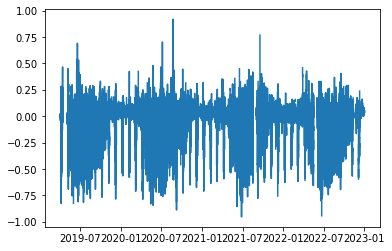

In [ ]:
import matplotlib.pyplot as plt
plt.plot(tmp_df.TIMESTAMP, tmp_df.NEE)
plt.show()
plt.plot(tmp_df.TIMESTAMP, tmp_df.co2_flux)
plt.show()


In [7]:
fluxDatas = get_site_flux()

FR-Fon


Backing off send_request(...) for 4.9s (requests.exceptions.ConnectionError: HTTPSConnectionPool(host='api.segment.io', port=443): Max retries exceeded with url: /v1/batch (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002CD2764BBE0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')))
Backing off send_request(...) for 21.0s (requests.exceptions.ConnectionError: HTTPSConnectionPool(host='api.segment.io', port=443): Max retries exceeded with url: /v1/batch (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002CD2764BE50>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')))


2019-04-01 00:30:00+00:00 2023-01-01 00:00:00+00:00
wco2


Backing off send_request(...) for 12.6s (requests.exceptions.ConnectionError: HTTPSConnectionPool(host='api.segment.io', port=443): Max retries exceeded with url: /v1/batch (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002CD2764B5E0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')))


Rows: 65807 Columns: 428
-- Column specification --------------------------------------------------------
Delimiter: ","
chr    (2): filename, filename_R
dbl  (355): DOY, daytime, file_records, used_records, Tau, qc_Tau, rand_err_...
lgl   (68): ch4_flux, qc_ch4_flux, rand_err_ch4_flux, none_flux, qc_none_flu...
dttm   (1): TIMESTAMP
date   (1): date
time   (1): time

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


R[write to console]: New sEddyProc class for site 'FluxSite'

R[write to console]: Initialized variable 'Tair' with 5887 real gaps for gap filling of all 65807 values (to estimate uncertainties).

R[write to console]: Limited MDS algorithm for gap filling of 'Tair' with LUT(Rg only) and MDC.

Backing off send_request(...) for 25.3s (requests.exceptions.ConnectionError: HTTPSConnectionPool(host='api.segment.io', port=443): Max retries exceeded with url: /v1/batch (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002CD2764BEE0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')))
R[write to console]: Finished gap filling of 'Tair' in 31 seconds. Artificial gaps filled: 65807, real gaps filled: 5887, unfilled (long) gaps: 0.

R[write to console]: Initialized variable 'Rg' with 17118 real gaps for gap filling of all 55727 values (to estimate uncertainties).

R[write to console]: Restriced MDS algorithm for gap filling of 'Rg' with no m

[1] "FilledEddyData 14:39"
  [1] "Tair_orig"                "Tair_f"                  
  [3] "Tair_fqc"                 "Tair_fall"               
  [5] "Tair_fall_qc"             "Tair_fnum"               
  [7] "Tair_fsd"                 "Tair_fmeth"              
  [9] "Tair_fwin"                "Rg_orig"                 
 [11] "Rg_f"                     "Rg_fqc"                  
 [13] "Rg_fall"                  "Rg_fall_qc"              
 [15] "Rg_fnum"                  "Rg_fsd"                  
 [17] "Rg_fmeth"                 "Rg_fwin"                 
 [19] "VPD_orig"                 "VPD_f"                   
 [21] "VPD_fqc"                  "VPD_fall"                
 [23] "VPD_fall_qc"              "VPD_fnum"                
 [25] "VPD_fsd"                  "VPD_fmeth"               
 [27] "VPD_fwin"                 "season"                  
 [29] "Ustar_uStar_Thres"        "Ustar_uStar_fqc"         
 [31] "NEE_uStar_orig"           "NEE_uStar_f"             
 [33] "NEE_uS

R[write to console]: New sEddyProc class for site 'FluxSite'

R[write to console]: Initialized variable 'Tair' with 5887 real gaps for gap filling of all 65807 values (to estimate uncertainties).

R[write to console]: Limited MDS algorithm for gap filling of 'Tair' with LUT(Rg only) and MDC.

R[write to console]: Finished gap filling of 'Tair' in 25 seconds. Artificial gaps filled: 65807, real gaps filled: 5887, unfilled (long) gaps: 0.

R[write to console]: Initialized variable 'Rg' with 17118 real gaps for gap filling of all 55727 values (to estimate uncertainties).

R[write to console]: Restriced MDS algorithm for gap filling of 'Rg' with no meteo conditions and hence only MDC.

R[write to console]: Finished gap filling of 'Rg' in 16 seconds. Artificial gaps filled: 55727, real gaps filled: 17118, unfilled (long) gaps: 10080.

R[write to console]: Initialized variable 'VPD' with 5897 real gaps for gap filling of all 65807 values (to estimate uncertainties).

R[write to console]: Lim

[1] "FilledEddyData 14:39"
 [1] "Tair_orig"         "Tair_f"            "Tair_fqc"         
 [4] "Tair_fall"         "Tair_fall_qc"      "Tair_fnum"        
 [7] "Tair_fsd"          "Tair_fmeth"        "Tair_fwin"        
[10] "Rg_orig"           "Rg_f"              "Rg_fqc"           
[13] "Rg_fall"           "Rg_fall_qc"        "Rg_fnum"          
[16] "Rg_fsd"            "Rg_fmeth"          "Rg_fwin"          
[19] "VPD_orig"          "VPD_f"             "VPD_fqc"          
[22] "VPD_fall"          "VPD_fall_qc"       "VPD_fnum"         
[25] "VPD_fsd"           "VPD_fmeth"         "VPD_fwin"         
[28] "season"            "Ustar_uStar_Thres" "Ustar_uStar_fqc"  
[31] "NEE_uStar_orig"    "NEE_uStar_f"       "NEE_uStar_fqc"    
[34] "NEE_uStar_fall"    "NEE_uStar_fall_qc" "NEE_uStar_fnum"   
[37] "NEE_uStar_fsd"     "NEE_uStar_fmeth"   "NEE_uStar_fwin"   
[40] "Ustar_U05_Thres"   "Ustar_U05_fqc"     "NEE_U05_orig"     
[43] "NEE_U05_f"         "NEE_U05_fqc"       "NEE_U05_fall"    

C:\Users\PHHERI~1\AppData\Local\Temp/ipykernel_7880/1463314769.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["DW_GPP"] = np.where((np.isnan(data.PPFD_IN) == False) * (data.PPFD_IN < 10), 0, 1) * (
C:\Users\PHHERI~1\AppData\Local\Temp/ipykernel_7880/1463314769.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["DW_Reco"] = (data["DW_NEE_uStar_f"] - data["DW_GPP"])


FR-Gri
wco2
Rows: 70126 Columns: 385
-- Column specification --------------------------------------------------------
Delimiter: ","
chr    (2): filename, filename_R
dbl  (312): DOY, daytime, file_records, used_records, Tau, qc_Tau, rand_err_...
lgl   (68): ch4_flux, qc_ch4_flux, rand_err_ch4_flux, none_flux, qc_none_flu...
dttm   (1): TIMESTAMP
date   (1): date
time   (1): time

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


R[write to console]: New sEddyProc class for site 'FluxSite'

R[write to console]: Initialized variable 'Tair' with 8367 real gaps for gap filling of all 66087 values (to estimate uncertainties).

R[write to console]: Limited MDS algorithm for gap filling of 'Tair' with LUT(Rg only) and MDC.

R[write to console]: Finished gap filling of 'Tair' in 24 seconds. Artificial gaps filled: 66087, real gaps filled: 8367, unfilled (long) gaps: 4039.

R[write to console]: Initialized variable 'Rg' with 50601 real gaps for gap filling of all 19679 values (to estimate uncertainties).

R[write to console]: Restriced MDS algorithm for gap filling of 'Rg' with no meteo conditions and hence only MDC.

R[write to console]: Finished gap filling of 'Rg' in 2 seconds. Artificial gaps filled: 19679, real gaps filled: 50601, unfilled (long) gaps: 50447.

R[write to console]: Initialized variable 'VPD' with 8377 real gaps for gap filling of all 66087 values (to estimate uncertainties).

R[write to console]: L

[1] "FilledEddyData 14:39"
  [1] "Tair_orig"                "Tair_f"                  
  [3] "Tair_fqc"                 "Tair_fall"               
  [5] "Tair_fall_qc"             "Tair_fnum"               
  [7] "Tair_fsd"                 "Tair_fmeth"              
  [9] "Tair_fwin"                "Rg_orig"                 
 [11] "Rg_f"                     "Rg_fqc"                  
 [13] "Rg_fall"                  "Rg_fall_qc"              
 [15] "Rg_fnum"                  "Rg_fsd"                  
 [17] "Rg_fmeth"                 "Rg_fwin"                 
 [19] "VPD_orig"                 "VPD_f"                   
 [21] "VPD_fqc"                  "VPD_fall"                
 [23] "VPD_fall_qc"              "VPD_fnum"                
 [25] "VPD_fsd"                  "VPD_fmeth"               
 [27] "VPD_fwin"                 "season"                  
 [29] "Ustar_uStar_Thres"        "Ustar_uStar_fqc"         
 [31] "NEE_uStar_orig"           "NEE_uStar_f"             
 [33] "NEE_uS

R[write to console]: New sEddyProc class for site 'FluxSite'

R[write to console]: Initialized variable 'Tair' with 8367 real gaps for gap filling of all 66087 values (to estimate uncertainties).

R[write to console]: Limited MDS algorithm for gap filling of 'Tair' with LUT(Rg only) and MDC.

R[write to console]: Finished gap filling of 'Tair' in 22 seconds. Artificial gaps filled: 66087, real gaps filled: 8367, unfilled (long) gaps: 4039.

R[write to console]: Initialized variable 'Rg' with 50601 real gaps for gap filling of all 19679 values (to estimate uncertainties).

R[write to console]: Restriced MDS algorithm for gap filling of 'Rg' with no meteo conditions and hence only MDC.

R[write to console]: Finished gap filling of 'Rg' in 2 seconds. Artificial gaps filled: 19679, real gaps filled: 50601, unfilled (long) gaps: 50447.

R[write to console]: Initialized variable 'VPD' with 8377 real gaps for gap filling of all 66087 values (to estimate uncertainties).

R[write to console]: L

[1] "FilledEddyData 14:39"
 [1] "Tair_orig"         "Tair_f"            "Tair_fqc"         
 [4] "Tair_fall"         "Tair_fall_qc"      "Tair_fnum"        
 [7] "Tair_fsd"          "Tair_fmeth"        "Tair_fwin"        
[10] "Rg_orig"           "Rg_f"              "Rg_fqc"           
[13] "Rg_fall"           "Rg_fall_qc"        "Rg_fnum"          
[16] "Rg_fsd"            "Rg_fmeth"          "Rg_fwin"          
[19] "VPD_orig"          "VPD_f"             "VPD_fqc"          
[22] "VPD_fall"          "VPD_fall_qc"       "VPD_fnum"         
[25] "VPD_fsd"           "VPD_fmeth"         "VPD_fwin"         
[28] "season"            "Ustar_uStar_Thres" "Ustar_uStar_fqc"  
[31] "NEE_uStar_orig"    "NEE_uStar_f"       "NEE_uStar_fqc"    
[34] "NEE_uStar_fall"    "NEE_uStar_fall_qc" "NEE_uStar_fnum"   
[37] "NEE_uStar_fsd"     "NEE_uStar_fmeth"   "NEE_uStar_fwin"   
[40] "Ustar_U05_Thres"   "Ustar_U05_fqc"     "NEE_U05_orig"     
[43] "NEE_U05_f"         "NEE_U05_fqc"       "NEE_U05_fall"    